In [17]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

RANDOM_SEED = 42

In [18]:
csv_file = 'keypoints\\keypointB_3D_full.csv'
model_save_path = 'model\\customModel\\modelB\\ASLclassifier4a.hdf5'
tflite_save_path = 'model\\customModel\\modelB\\ASLclassifier4a.tflite'

In [19]:
NUM_CLASSES = 28
num_identifier_columns = 1
coord_dimensions = 3

In [20]:
# lst = [1] + list(range(num_identifier_columns, (21 * 2) + num_identifier_columns))
lst = list(range(num_identifier_columns, 21 * coord_dimensions + num_identifier_columns + 1))
X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=lst)

In [21]:
y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='<U8', usecols=0)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [23]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target data to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * coord_dimensions + 1, )),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [25]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 80)                5200      
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                4050      
                                                                 
 dense_5 (Dense)             (None, 28)                1428      
                                                                 
Total params: 10,678
Trainable params: 10,678
Non-trainable params: 0
_________________________________________________________________


In [26]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [27]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
model.fit(
    X_train,
    y_train_encoded,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test_encoded),
    callbacks=[es_callback]    # callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
694/694 [==============================] - 4s 3ms/step - loss: 1.4357 - accuracy: 0.5497 - val_loss: 0.4918 - val_accuracy: 0.8848
Epoch 2/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.7547 - accuracy: 0.7354 - val_loss: 0.3610 - val_accuracy: 0.9131
Epoch 3/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.6156 - accuracy: 0.7862 - val_loss: 0.2819 - val_accuracy: 0.9293
Epoch 4/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.5195 - accuracy: 0.8206 - val_loss: 0.2356 - val_accuracy: 0.9498
Epoch 5/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.4532 - accuracy: 0.8468 - val_loss: 0.2065 - val_accuracy: 0.9632
Epoch 6/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.4038 - accuracy: 0.8667 - val_loss: 0.1914 - val_accuracy: 0.9621
Epoch 7/1000
694/694 [==============================] - 2s 3ms/step - loss: 0.3613 - accuracy: 0.8834 - val_loss: 0.1761 - val_accuracy:

In [29]:
val_loss, val_acc = model.evaluate(X_test, y_test_encoded, batch_size=128)

174/174 [==============================] - 0s 1ms/step - loss: 0.1492 - accuracy: 0.9529


In [30]:
# model = tf.keras.models.load_model(model_save_path)

In [31]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 100ms/step
[5.28966697e-11 5.29437944e-15 6.50254628e-10 1.51895954e-10
 3.57475716e-09 3.56865815e-10 1.50886976e-07 2.41817015e-05
 2.72425593e-09 8.29315905e-09 4.15654923e-19 4.27257334e-07
 7.40146277e-07 1.42389445e-05 5.88312168e-12 9.99505043e-01
 3.99269280e-04 3.82329455e-12 3.85791015e-14 3.14098081e-09
 1.31292912e-13 2.41228287e-16 2.25659043e-15 3.30803291e-17
 1.10094347e-11 4.69335191e-06 5.12063343e-05 4.59821115e-09]
15


694/694 [==============================] - 1s 989us/step


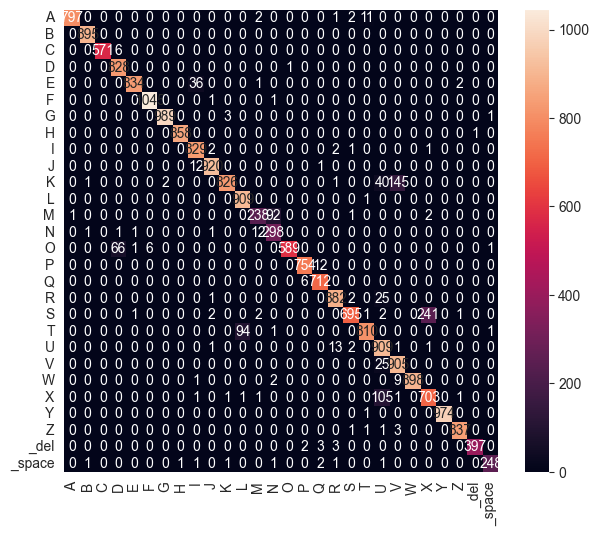

Classification Report
              precision    recall  f1-score   support

           A       1.00      0.98      0.99       813
           B       1.00      1.00      1.00       895
           C       1.00      0.99      0.99       577
           D       0.92      1.00      0.96       829
           E       1.00      0.96      0.98       873
           F       0.99      1.00      1.00      1047
           G       1.00      1.00      1.00       993
           H       1.00      1.00      1.00       859
           I       0.94      0.99      0.97       835
           J       0.99      0.99      0.99       933
           K       0.99      0.81      0.89      1015
           L       0.91      1.00      0.95       910
           M       0.93      0.71      0.81       334
           N       0.75      0.95      0.84       314
           O       1.00      0.89      0.94       663
           P       0.99      0.98      0.99       766
           Q       0.98      0.99      0.98       718
     

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

label_encoder.fit(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print_confusion_matrix(y_test_decoded, y_pred_decoded)

# Tensorflow-Lite

In [33]:
model.save(model_save_path, include_optimizer=False)

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpo34jab3j\assets


INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpo34jab3j\assets


13448

In [35]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [36]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [37]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [38]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [39]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.6808377e-12 7.7327184e-16 3.1143393e-10 8.5567612e-12 7.6506206e-09
 2.7285513e-10 7.1341844e-07 1.1902310e-05 3.0846101e-09 5.7827734e-09
 6.0901793e-20 2.1867845e-07 1.1527546e-07 4.3830601e-06 5.0425159e-13
 9.9965811e-01 3.0383718e-04 4.8586786e-14 4.5246081e-14 1.1506270e-09
 1.7015601e-14 6.9322751e-17 1.4141276e-16 7.7052139e-17 4.8895402e-12
 6.1342820e-07 2.0025602e-05 2.8286062e-09]
15
